# gpu

In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 28 08:22:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


### Load Data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/동아리/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/동아리/Test.csv')

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

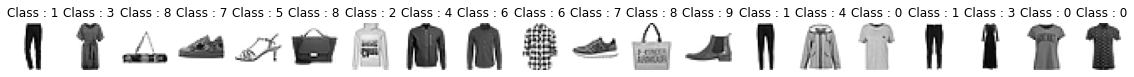

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.values

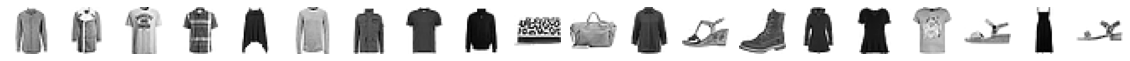

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
X = X / 255.0
X_test = X_test / 255.0
print("Images shape after normalization = ",X.shape)

Images shape after normalization =  (59500, 784)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.FloatTensor(X_test)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)
print("x_val shape = ",X_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  torch.Size([47600, 784])
y_train shape =  torch.Size([47600])
x_val shape =  torch.Size([11900, 784])
y_val shape =  torch.Size([11900])


### train

In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

BATCH_SIZE = 128

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [19]:
import torch
from torch import optim

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 20

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # 모델에서 훈련
        result = model(images)
        # 오차 계산
        loss = criterion(result, labels)
        # 초기화
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 스텝
        optimizer.step()
        # 오차값을 총 오차에 더함
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 0.5885172801152352
Training loss: 0.3980291361209526
Training loss: 0.36677036746855707
Training loss: 0.33559530769144336
Training loss: 0.31477948678757556
Training loss: 0.30051000424290214
Training loss: 0.28843431687483223
Training loss: 0.2758135328930552
Training loss: 0.26974563392740425
Training loss: 0.25901412080612873
Training loss: 0.2495437790389343
Training loss: 0.24146549920401267
Training loss: 0.23240001820107942
Training loss: 0.2282363810646598
Training loss: 0.22432532944586328
Training loss: 0.21654430766820268
Training loss: 0.21199572915511747
Training loss: 0.20378336969322414
Training loss: 0.20216123511393866
Training loss: 0.20177719840199076


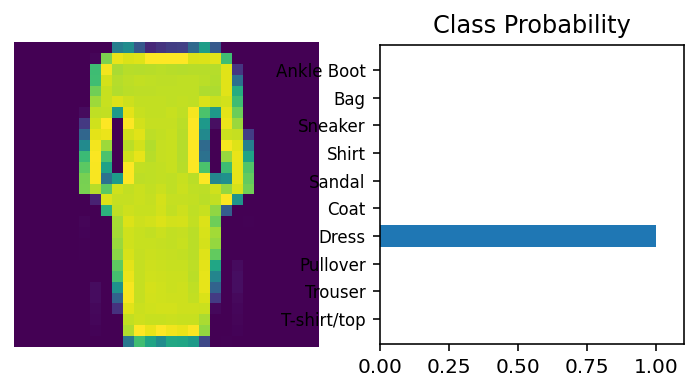

In [34]:
import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):

    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt','Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

dataiter_ = iter(val_loader)
images, labels = next(dataiter)
img = images[0]
img = img.resize_(1, 784)
ps = torch.exp(model(img))
view_classify(img, ps, version='Fashion')
# val dataset에서의 dress를 잘 맞추고 있습니다 

In [36]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # for 문이 끝나면 실행
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        # 자동 미분을 꺼서 pytorch가 쓸 떼 없는 짓을 안하게 한다. (어차피 test set에서 하는 작업이므로)
        with torch.no_grad():
            for images, labels in val_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                # 로그 확률에 지수 적용
                ps = torch.exp(log_ps)
                # topk는 k번째로 큰 숫자를 찾아내는 것이다.
                # dim=1 는 dimension을 의미한다.
                top_p, top_class = ps.topk(1, dim=1)
                # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)
                # equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(val_loader)))

Epoch: 1/30..  Training Loss: 0.589..  Test Loss: 0.463..  Test Accuracy: 0.831
Epoch: 2/30..  Training Loss: 0.404..  Test Loss: 0.383..  Test Accuracy: 0.857
Epoch: 3/30..  Training Loss: 0.362..  Test Loss: 0.354..  Test Accuracy: 0.871
Epoch: 4/30..  Training Loss: 0.339..  Test Loss: 0.340..  Test Accuracy: 0.877
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.337..  Test Accuracy: 0.880
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.339..  Test Accuracy: 0.875
Epoch: 7/30..  Training Loss: 0.286..  Test Loss: 0.326..  Test Accuracy: 0.886
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.314..  Test Accuracy: 0.888
Epoch: 9/30..  Training Loss: 0.266..  Test Loss: 0.315..  Test Accuracy: 0.888
Epoch: 10/30..  Training Loss: 0.259..  Test Loss: 0.325..  Test Accuracy: 0.886
Epoch: 11/30..  Training Loss: 0.249..  Test Loss: 0.324..  Test Accuracy: 0.890
Epoch: 12/30..  Training Loss: 0.246..  Test Loss: 0.318..  Test Accuracy: 0.889
Epoch: 13/30..  Training Loss: 0.238.

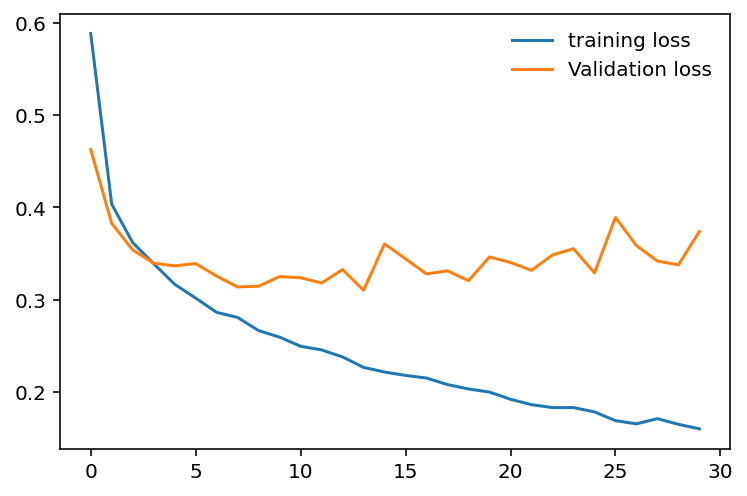

In [37]:
# loss 확인
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

training loss는 점차 감소하지만, validation loss는 그렇지 못합니다. 오버피팅을 방지하기 위해 드롭아웃을 추가해보겠습니다.

In [38]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # 0.2정도를 무작위로 골라 dropout한다.
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output은 dropout하면 안된다..
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [45]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 50
steps = 0

train_losses, test_losses, val_acc = [], [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))
        val_acc.append(accuracy/len(val_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(val_loader)))

Epoch: 1/50..  Training Loss: 0.663..  Test Loss: 0.425..  Test Accuracy: 0.844
Epoch: 2/50..  Training Loss: 0.469..  Test Loss: 0.404..  Test Accuracy: 0.855
Epoch: 3/50..  Training Loss: 0.425..  Test Loss: 0.355..  Test Accuracy: 0.872
Epoch: 4/50..  Training Loss: 0.405..  Test Loss: 0.353..  Test Accuracy: 0.868
Epoch: 5/50..  Training Loss: 0.389..  Test Loss: 0.363..  Test Accuracy: 0.871
Epoch: 6/50..  Training Loss: 0.377..  Test Loss: 0.328..  Test Accuracy: 0.879
Epoch: 7/50..  Training Loss: 0.362..  Test Loss: 0.336..  Test Accuracy: 0.882
Epoch: 8/50..  Training Loss: 0.358..  Test Loss: 0.324..  Test Accuracy: 0.883
Epoch: 9/50..  Training Loss: 0.348..  Test Loss: 0.332..  Test Accuracy: 0.882
Epoch: 10/50..  Training Loss: 0.336..  Test Loss: 0.317..  Test Accuracy: 0.885
Epoch: 11/50..  Training Loss: 0.334..  Test Loss: 0.320..  Test Accuracy: 0.885
Epoch: 12/50..  Training Loss: 0.331..  Test Loss: 0.323..  Test Accuracy: 0.884
Epoch: 13/50..  Training Loss: 0.326.

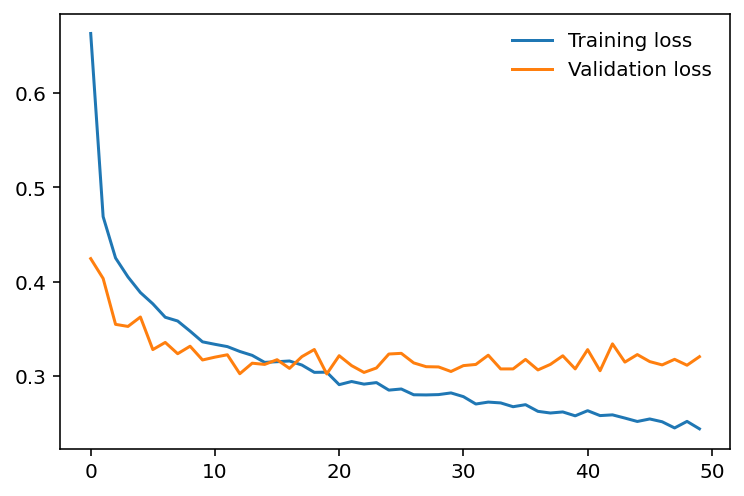

In [46]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

overfitting 문제가 해결되었습니다.

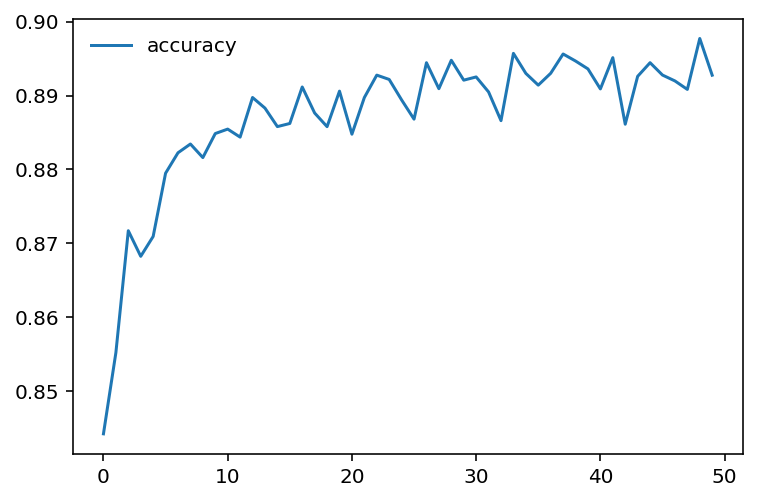

In [47]:
plt.plot(val_acc, label='accuracy')
plt.legend(frameon=False)